In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import time
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
import project_path
from src.util.generate_connected_graph import generate_connected_graph
from src.util.generate_lr_data import generate_low_rank_data
from src.util.generate_anomaly import generate_spatio_temporal_anomaly
# from src.algos.lr_stss import lr_stss
from src.algos.lr_stss_modified import lr_stss_modified
from src.algos.lr_sts import lr_sts_hard
from src.algos.lr_sss import lr_sss_hard
from src.algos.horpca_singleton import horpca_singleton
from dask.distributed import as_completed
from tqdm import tqdm

In [2]:
client = Client( n_workers=125)
client

/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36639 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36639/status,
Dashboard: http://127.0.0.1:36639/status,Workers: 125
Total threads: 250,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40491,Workers: 125
Dashboard: http://127.0.0.1:36639/status,Total threads: 250
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:33623,Total threads: 2
Dashboard: http://127.0.0.1:45504/status,Memory: 819.20 MiB
Nanny: tcp://127.0.0.1:45141,


In [3]:
def bp_wavelet_kernel(x, alpha, beta, x2, x1=1):
    g = np.zeros(len(x))

    a1= (alpha*x2 - beta*x1)/(x1*x2*(x1 - x2)*(x1 - x2))
    a2=-(2*alpha*x2**2 - 2*beta*x1**2 + alpha*x1*x2 - beta*x1*x2)/(x1*x2*(x1 - x2)*(x1 - x2))
    a3= (-beta*x1**3 - 2*beta*x1**2*x2 + 2*alpha*x1*x2**2 + alpha*x2**3)/(x1*x2*(x1 - x2)*(x1 - x2))
    a4=(beta*x1**2 - alpha*x2**2 - 2*x1*x2 + x1**2 + x2**2)/(x1**2 - 2*x1*x2 + x2**2)

    g[x<x1] = np.power((x[x<x1]/x1),alpha)

    band = (x>=x1) * ( x<=x2)
    g[band] = a1*np.power(x[band],3) + a2*np.power(x[band],2) + a3*x[band] + a4 
    
    g[x>x2] = np.power(x2/x[x>x2], beta)
    return g

In [4]:
## Control Variables
gt = 'grid'
graph_param = (8,5)
dtn = 4
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (40,24,7,20)
ranks = (8,8,5,4)
NoG = 1
NoT = 10
NoA = 100
time_m = 2
local_m = 1
lda_2 = 1000
psi = 20
maxit = 200
## Independent variables
### Hyperparameters
radius = np.array([0,1,2,3,4,5])
lda_1 = 0.00012104 # 0.0003542734521053448 # np.logspace(1,-3,5)
lda_l = 0.00016974 # 0.002062120382 # np.logspace(1,-3,5)
lda_t = 0.00010008 # 0.00013502437304801454 # np.logspace(1,-3,5)

metadata = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': radius,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'time_mode': time_m,
            'local_mode': local_m,
            'lda_2':lda_2,
            'lda_1':lda_1,
            'lda_l':lda_l,
            'lda_t':lda_t,
            'psi': psi,
            'maxit':maxit,
            }

metadata_horpca = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': radius,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'maxit':maxit,
            }
# Define experiment function
def run_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    psi = inputs['psi']
    res = lr_stss_modified(Y, An, time_m,local_m, verbose=0, max_it=maxit,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsts_exp(X,Y,an_m,inputs):
    psi = inputs['psi']
    res = lr_sts_hard(Y, time_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_lrsss_exp(X,Y,an_m,inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    L = np.eye(Y.shape[local_m-1]) - An
    psi = inputs['psi']
    res = lr_sss_hard(Y, L, local_m, verbose=0, max_it=maxit,
        lda1=inputs['lda_1'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

    
def run_horpca_exp(X,Y, an_m, inputs):
    res = horpca_singleton(Y, lda1=1/np.sqrt(np.max(Y.shape)), rho=1, step_size_growth=-1, maxit=maxit, verbose=0)
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['E']).ravel()),
              'rec_err': np.linalg.norm(res['Y']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies':NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': 1/np.sqrt(np.max(Y.shape)),
              'psi':1,
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it']}
    return result

def run_wavelet_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    L = np.eye(An.shape[0]) - An
    w, V = np.linalg.eigh(L)
    beta = 1/np.log10(w[2]/w[1])
    alpha = 2
    x1 = 1
    x2 = w[-1]/w[1]
    s = 1/w[1]# inputs['wavelet_scale']
    g = bp_wavelet_kernel(s*w, alpha,beta,x2)
    Phi = V@ np.diag(g) @V.T
    psi = inputs['psi']
    res = lr_stss_modified(Y, An, time_m,local_m, verbose=0, max_it=maxit,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi], L=Phi)
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi':psi,
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit,
              'rho': res['rho'][-1],
              'trial': inputs['trial'],
              'it': res['it'],
              'wavelet_scale': s}
    return result

In [5]:
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_exp3_1.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp3_1.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp3_1.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp3_1.hdf5')
fname_wavelet = os.path.join(cwd, 'results','wavelet_exp3_1.hdf5')
key = 'grid'

if True:
    try:
        del futures_lrssts
    except:
        pass
    try:
        del futures_horpca
    except:
        pass
    try:
        del futures_lrsts
    except:
        pass
    try:
        del futures_lrsss
    except:
        pass
    try:
        del futures_wavelet
    except:
        pass

seed = 12345678+4000
input_ = {}
for i in range(NoG):
    G,sd = generate_connected_graph(graph_param, gt, radius=graph_param, seed=seed)
    input_['G'] = G
    input_['graph_type'] = gt
    input_['graph_seed'] = sd
    seed = sd
    futures_lrssts = []
    futures_horpca = []
    futures_lrsts = []
    futures_lrsss = []
    futures_wavelet = []
    results=[[],[],[],[], []]
    for j in tqdm(range(NoT)):
        
        # Generate low rank normal data
        X = generate_low_rank_data(dims, ranks, seed)
        X = 1*X/np.std(X)
        input_['X'] = X
        input_['trial'] = j
        # Generate anomaly
        for k in range(len(radius)):
            input_['radius']= radius[k]
            an, an_m = generate_spatio_temporal_anomaly(dims, G, NoA, duration=dtn,
                                                        radius=radius[k], seed=seed,
                time_m=time_m, local_m=local_m, window_type='boxcar', amplitude=amp,
                distribution=distribution, local_dist='constant')
            input_['anomaly_seed'] = seed
            Y = X+an
            seed +=1
            # LR_SSTS Submissions
            input_['lda_1'] = lda_1
            input_['lda_l'] = lda_l
            input_['lda_t'] = lda_t
            input_['lda_2'] = lda_2
            input_['psi'] = psi
            futures_lrssts.append(client.submit(run_exp, X, Y, an_m, input_))

            # Wavelet Submissions
            futures_wavelet.append(client.submit(run_wavelet_exp, X,Y, an_m, input_))

            # LR_SSS lda_t=0 Submissions
            input_['lda_t'] = 0
            input_['lda_l'] = 0.1166 # 0.2921
            input_['lda_1'] = 1.14795# 8.375634044352
            futures_lrsss.append(client.submit(run_lrsss_exp, X,Y,an_m, input_))
            # LR_STS lda_l=0 Submissions
            input_['lda_t'] = 0.2
            input_['lda_l'] = 0
            input_['lda_1'] = 1.2
            futures_lrsts.append(client.submit(run_lrsts_exp, X, Y, an_m, input_))

            # HoRPCA Submissions
            futures_horpca.append(client.submit(run_horpca_exp, X,Y, an_m, input_))
            
            

for future in as_completed(futures_lrssts):
    results[0].append(future.result())
    del future

for future in as_completed(futures_lrsts):
    results[1].append(future.result())
    del future

for future in as_completed(futures_lrsss):
    results[2].append(future.result())
    del future

for future in as_completed(futures_horpca):
    results[3].append(future.result())
    del future

for future in as_completed(futures_wavelet):
    results[4].append(future.result())
    del future

idx = np.arange(len(results[0]))
df = pd.DataFrame(results[0], index=idx)
with pd.HDFStore(fname_lrssts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[1]))
df = pd.DataFrame(results[1], index=idx)
with pd.HDFStore(fname_lrsts) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[2]))
df = pd.DataFrame(results[2], index=idx)
with pd.HDFStore(fname_lrsss) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

idx = np.arange(len(results[3]))
df = pd.DataFrame(results[3], index=idx)
with pd.HDFStore(fname_horpca) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata_horpca

idx = np.arange(len(results[4]))
df = pd.DataFrame(results[4], index=idx)
with pd.HDFStore(fname_wavelet) as storedata:
    storedata.append(key, df)
    storedata.get_storer(key).attrs.metadata=metadata

for i in range(len(results)):
    del results[-1]
        

Graph is connected.


 10%|████▍                                       | 1/10 [00:00<00:05,  1.69it/s]/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/worker.py:2995: UserWarning: Large object of size 2.18 MiB detected in task graph: 
  (array([[[[-1.20703757e+00,  2.26114589e+00, -1.08 ... 00, 'psi': 20})
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


In [7]:
from dask.distributed import as_completed

fname = 'lr_stss_exp3_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)

for future in as_completed(futures):
    df = pd.DataFrame(future.result(), index=[i])
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
    del future
    
with pd.HDFStore(fname) as storedata:
    storedata.get_storer(key).attrs.metadata=metadata

2023-06-26 10:34:23,243 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/tornado/websocket.py", line 942, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/tornado/web.py", line 3208, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [10]:
cwd = os.getcwd()
fname_lrssts = os.path.join(cwd, 'results','lrstss_exp3_1.hdf5')
fname_horpca = os.path.join(cwd, 'results','horpca_exp3_1.hdf5')
fname_lrsts = os.path.join(cwd, 'results','lrsts_exp3_1.hdf5')
fname_lrsss = os.path.join(cwd, 'results','lrsss_exp3_1.hdf5')
fname_wavelet = os.path.join(cwd, 'results','wavelet_exp3_1.hdf5')
key = 'grid'

with pd.HDFStore(fname_lrssts) as storedata:
    df_lrssts = storedata[key]
with pd.HDFStore(fname_lrsts) as storedata:
    df_lrsts = storedata[key]
with pd.HDFStore(fname_lrsss) as storedata:
    df_lrsss = storedata[key]
with pd.HDFStore(fname_horpca) as storedata:
    df_horpca = storedata[key]
with pd.HDFStore(fname_wavelet) as storedata:
    df_wavelet = storedata[key]

dfm_lrstss = df_lrssts.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrstss_2 = df_lrssts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrstss = dfm_lrstss.groupby(['anomaly_radius'])['auc'].max().reset_index()
dfm2_lrstss_2 = dfm_lrstss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(df_lrssts.to_html()))

dfm_lrsts = df_lrsts.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsts_2 = df_lrsts.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsts = dfm_lrsts.groupby(['anomaly_radius'])['auc'].max().reset_index()
dfm2_lrsts_2 = dfm_lrsts_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsts_2.to_html()))

dfm_lrsss = df_lrsss.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_lrsss_2 = df_lrsss.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_lrsss = dfm_lrsss.groupby(['anomaly_radius'])['auc'].max().reset_index()
dfm2_lrsss_2 = dfm_lrsss_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm2_lrsss_2.to_html()))

dfm_horpca_2 = df_horpca.groupby(['anomaly_cardinality'])[['auc','rec_err']].mean().reset_index()
dfm_horpca = df_horpca.groupby(['anomaly_radius'])[['auc', 'rec_err']].mean().reset_index()
dfm_horpca_std = df_horpca.groupby(['anomaly_radius'])[['auc', 'rec_err']].std()
# display(HTML(dfm_horpca_2.to_html()))

dfm_wavelet = df_wavelet.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm_wavelet_2 = df_wavelet.groupby(['anomaly_cardinality','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2_wavelet = dfm_wavelet.groupby(['anomaly_radius'])['auc'].max().reset_index()
dfm2_wavelet_2 = dfm_wavelet_2.groupby(['anomaly_cardinality'])['auc'].max().reset_index()
# display(HTML(dfm_wavelet.to_html()))


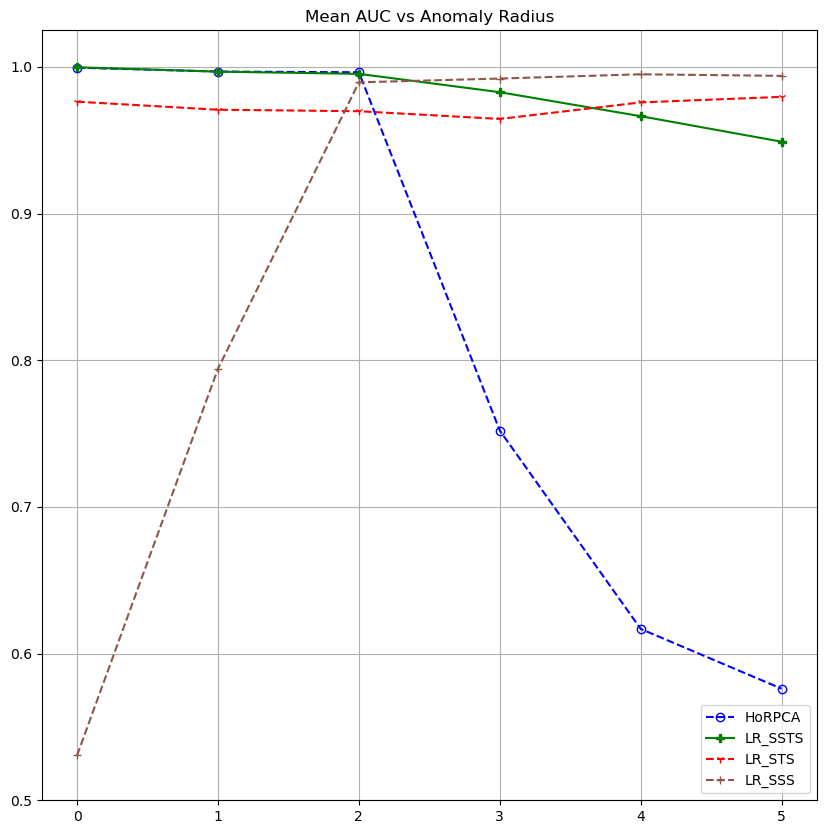

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
# dfm2.plot() /(7*24*20*40)
ax.plot(dfm_horpca['anomaly_radius'],dfm_horpca['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
ax.plot(dfm2_lrstss['anomaly_radius'],dfm2_lrstss['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
ax.plot(dfm2_lrsts['anomaly_radius'],dfm2_lrsts['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
ax.plot(dfm2_lrsss['anomaly_radius'],dfm2_lrsss['auc'], label='LR_SSS', linestyle='--',marker='+', fillstyle='none', c='C5')
# ax.plot(dfm2_wavelet['anomaly_radius'],dfm2_wavelet['auc'], label='Wavelet', linestyle='--',marker='+', fillstyle='none', c='C6')
# ax.plot(dfm_horpca_2['anomaly_cardinality']/(7*24*20*40),dfm_horpca_2['auc'], label='HoRPCA', linestyle='--',marker='o',  fillstyle='none', c='b')
# ax.plot(dfm2_lrstss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrstss_2['auc'], label='LR_SSTS', linestyle='-',marker='P', c='g')
# ax.plot(dfm2_lrsts_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsts_2['auc'], label='LR_STS', linestyle='--',marker='1', fillstyle='none', c='r')
# ax.plot(dfm2_lrsss_2['anomaly_cardinality']/(7*24*20*40),dfm2_lrsss_2['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
# ax.plot(dfm2_wavelet_2['anomaly_cardinality']/(7*24*20*40),dfm2_wavelet_2['auc'], label='LR_SSS', linestyle=':',marker='+', fillstyle='none', c='y')
ax.grid()
ax.set_title("Mean AUC vs Anomaly Radius");
ax.set_ylim([0.5,1.025]);
ax.legend()

In [43]:
import seaborn as sns
dfm = df.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2 = dfm.groupby(['anomaly_radius'])['auc'].max()
display(HTML(dfm.to_html()))
# sns.pairplot(dfm)

In [39]:
df.columns
columns = df.columns[1:4].union(df.columns[6:7]).union(df.columns[10:11]).union(df.columns[12:14])
# sns.pairplot(df[columns])
df[columns].corr()

,anomaly_cardinality,anomaly_radius,auc,lda_1,lda_l,lda_t,rec_err
anomaly_cardinality,1.000000e+00,9.939364e-01,-0.045175,2.331594e-17,1.376121e-16,2.128481e-16,0.176418
anomaly_radius,9.939364e-01,1.000000e+00,-0.041829,-3.522787e-17,9.795688e-17,1.876787e-16,0.178880
auc,-4.517504e-02,-4.182914e-02,1.000000,-3.186580e-02,2.101256e-01,-1.786278e-01,-0.524636
lda_1,2.331594e-17,-3.522787e-17,-0.031866,1.000000e+00,-1.067757e-17,-4.186653e-17,-0.345483
lda_l,1.376121e-16,9.795688e-17,0.210126,-1.067757e-17,1.000000e+00,-1.245231e-17,-0.417025
lda_t,2.128481e-16,1.876787e-16,-0.178628,-4.186653e-17,-1.245231e-17,1.000000e+00,-0.376254
rec_err,1.764179e-01,1.788798e-01,-0.524636,-3.454828e-01,-4.170253e-01,-3.762535e-01,1.000000


anomaly_radius
0    0.999987
1    0.997724
2    0.995491
3    0.989923
Name: auc, dtype: float64

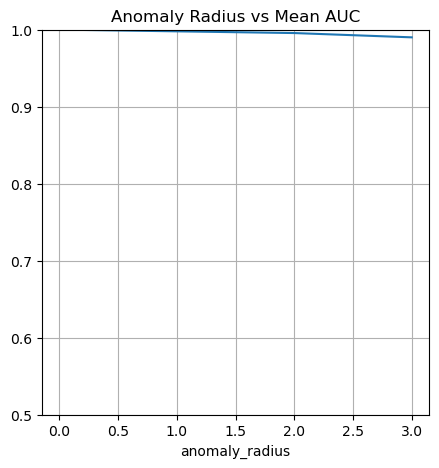

In [44]:
display(dfm2)
fig = plt.figure(figsize=(5,5))
dfm2.plot()
plt.grid()
plt.title("Anomaly Radius vs Mean AUC");
plt.ylim([0.5,1]);

In [10]:
client.shutdown()

2023-08-16 07:01:56,517 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/worker.py", line 1238, in heartbeat
    response = await retry_operation(
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/utils_comm.py", line 434, in retry_operation
    return await retry(
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/utils_comm.py", line 413, in retry
    return await coro()
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/core.py", line 136